## 4 Channel, CNN , Sun+Sky

In [1]:
# Math
import numpy as np
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import StepLR
# Custom
from loader import IlluminationModule_Shadow, Train_Shadow_Dataset, Eval_Shadow_Dataset
import os
from libs.projections import bin2Sphere
from utils import getAngle

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
BATCH_SIZE = 64
EPOCHS = 500

# 하이퍼파라미터 설정
learning_rate = 0.01

In [4]:
dataset = Train_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [5]:
eval_dataset = Eval_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
test_loader = eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [6]:
illuminationModule = IlluminationModule_Shadow().cuda()

In [7]:
from torchsummary import summary

summary(illuminationModule, input_size=(4,320,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 120]          12,608
       BatchNorm2d-2         [-1, 64, 160, 120]             128
               ELU-3         [-1, 64, 160, 120]               0
            Conv2d-4          [-1, 128, 80, 60]         204,928
       BatchNorm2d-5          [-1, 128, 80, 60]             256
               ELU-6          [-1, 128, 80, 60]               0
            Conv2d-7          [-1, 256, 40, 30]         295,168
       BatchNorm2d-8          [-1, 256, 40, 30]             512
               ELU-9          [-1, 256, 40, 30]               0
           Conv2d-10          [-1, 256, 40, 30]         590,080
      BatchNorm2d-11          [-1, 256, 40, 30]             512
              ELU-12          [-1, 256, 40, 30]               0
           Conv2d-13          [-1, 256, 20, 15]         590,080
      BatchNorm2d-14          [-1, 256,

In [8]:
sun_crit = nn.KLDivLoss()
prr_crit = nn.MSELoss()
# set optimizer
optimizer = optim.Adam(illuminationModule.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [9]:
def trainloop(module, lr=0.01, train_epochs=EPOCHS):
    global total_l, sky_l, sun_l
    # set training dataset
    dataset = Train_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    # using KL divergence loss for sun distribution and MSE loss  
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()
    # set optimizer
    optimizer = torch.optim.Adam(module.parameters(), lr=lr)

    # train the model
    cur_lr = lr

    for i in range(train_epochs):
        module.train()
        for i_batch, sample in enumerate(train_dataloader):
            # training input and targets
            img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()

            # forward pass 
            pred_dis, pred_prrs = module(img)
            beta = 0.1 # to compensate for the number od bins in output distribution
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            loss = sun_loss + beta * prr_loss

            # optimization
            #if i_batch % 10 == 0 :
                #print('epoch:', i+1, 'steps:', i_batch+1, "sun_loss: ", 'loss:', loss.item())
            #    print('EPOCH : %d, STEPS : %d, sun_loss : %.5f, prr_loss : %.5f, loss : %.5f'%(i+1, i_batch+1, sun_loss.item(), prr_loss.item(), loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_l.append(loss.item())
        sun_l.append(sun_loss.item())
        sky_l.append(prr_loss.item())
        
        print('='*20,'EPOCH : ', i,'='*20)
        print('-'*20,'TRAIN','-'*20)
        print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
        print('-'*20,'TEST','-'*20)
        evaluate(module, eval_dataloader, optimizer, train_epochs)
        
        # Decay learning rate (0.5/15 epochs)
        if i % 15 == 0:
            cur_lr *= 0.5
            update_lr(optimizer, cur_lr)
        

    # Save the model checkpoint
    torch.save(module.state_dict(), 'shadow_17_9_weights.pth')

In [10]:
test_total_l = []
test_sun_l = []
test_sky_l = []


def evaluate(module, eval_dataloader, optimizer, epoch):
    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    
    for i, sample in enumerate(eval_dataloader):
        num_of_mini_batch = len(eval_dataloader)
        input_img = sample['img'].cuda().float()
        label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
        sunpos = sample['sp'][0].numpy()

        with torch.no_grad():
            #print("="*20,i,"="*20)
            pred_dis, pred_prrs = module(input_img)
            #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
            #print("pred_dis : ", pred_dis)
            #print("pred_prrs : ", pred_prrs)
            #print(input_img)
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            beta = 0.1
            loss = sun_loss + beta * prr_loss

            sum_loss += loss.item()
#                print("sum_loss : " , sum_loss)

            # calculate all prediction error
            bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
            pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
            #print('pred_sunpos : ', pred_sunpos)
            suns.append(pred_sunpos)
            suns_gt.append(sunpos)
            sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
            angular.append(sunpos_err)
            # Sky sun kappa beta turbidity
            sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
            sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
            kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
            beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
            tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
            sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])

#            if i % 5 == 0:
#                print("({:.0f}%)   sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(100.*i / num_of_mini_batch, sun_loss.item(), prr_loss.item(), loss.item()))

    print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
    if epoch == 499:    
        print("="*20,"FINAL ERROR","="*20)
    #    print('Testing avg loss:', sum_loss/data_length)
        final_err = sum_err/data_length
    #    print('Average predictions error:')
        print('sun position (angular error):', final_err[0])
        print('sky color error :', final_err[1])
        print('sun color error:', final_err[2])
        print('kappa error :', final_err[3])
        print('beta error:', final_err[4])
        print('turbidity error:', final_err[5])

    test_total_l.append(loss.item())
    test_sun_l.append(sun_loss.item())
    test_sky_l.append(prr_loss.item())
    return suns_gt, suns, bins, angular

In [11]:
def main():

    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    Module = IlluminationModule_Shadow().cuda()

    trainloop(Module)
    
total_l = []
sun_l = []
sky_l = []

if __name__ == '__main__':
    main()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


==================== EPOCH :  0 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01456,  prr_loss : 67.35551,  loss : 6.75011 
-------------------- TEST --------------------
sun_loss : 0.03558,  prr_loss : 62.39469,  loss : 6.27505 
==================== EPOCH :  1 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01409,  prr_loss : 53.23743,  loss : 5.33783 
-------------------- TEST --------------------
sun_loss : 0.01370,  prr_loss : 57.20903,  loss : 5.73460 
==================== EPOCH :  2 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01197,  prr_loss : 50.65401,  loss : 5.07737 
-------------------- TEST --------------------
sun_loss : 0.01265,  prr_loss : 56.24199,  loss : 5.63684 
==================== EPOCH :  3 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01323,  prr_loss : 57.72200,  loss : 5.78543 
-------------------- TEST ----------------

sun_loss : 0.01141,  prr_loss : 46.46207,  loss : 4.65762 
==================== EPOCH :  31 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01070,  prr_loss : 43.32882,  loss : 4.34358 
-------------------- TEST --------------------
sun_loss : 0.01133,  prr_loss : 46.49225,  loss : 4.66055 
==================== EPOCH :  32 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01000,  prr_loss : 49.75048,  loss : 4.98505 
-------------------- TEST --------------------
sun_loss : 0.01131,  prr_loss : 46.16357,  loss : 4.62767 
==================== EPOCH :  33 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01147,  prr_loss : 48.12597,  loss : 4.82407 
-------------------- TEST --------------------
sun_loss : 0.01122,  prr_loss : 46.99171,  loss : 4.71040 
==================== EPOCH :  34 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01088,  prr_loss : 48.497

sun_loss : 0.01107,  prr_loss : 43.64013,  loss : 4.37508 
==================== EPOCH :  62 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01004,  prr_loss : 40.99016,  loss : 4.10906 
-------------------- TEST --------------------
sun_loss : 0.01113,  prr_loss : 43.36264,  loss : 4.34739 
==================== EPOCH :  63 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01037,  prr_loss : 47.74743,  loss : 4.78511 
-------------------- TEST --------------------
sun_loss : 0.01107,  prr_loss : 42.95435,  loss : 4.30650 
==================== EPOCH :  64 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01018,  prr_loss : 56.21807,  loss : 5.63199 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 43.28316,  loss : 4.33934 
==================== EPOCH :  65 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01109,  prr_loss : 44.279

sun_loss : 0.01103,  prr_loss : 42.70002,  loss : 4.28103 
==================== EPOCH :  93 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00996,  prr_loss : 51.00537,  loss : 5.11050 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.60106,  loss : 4.27113 
==================== EPOCH :  94 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00960,  prr_loss : 45.86882,  loss : 4.59648 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.54893,  loss : 4.26590 
==================== EPOCH :  95 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00970,  prr_loss : 47.71820,  loss : 4.78152 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.48289,  loss : 4.25929 
==================== EPOCH :  96 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01023,  prr_loss : 39.079

sun_loss : 0.01102,  prr_loss : 42.38172,  loss : 4.24919 
==================== EPOCH :  124 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01054,  prr_loss : 43.05784,  loss : 4.31632 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.26389,  loss : 4.23742 
==================== EPOCH :  125 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00959,  prr_loss : 47.85690,  loss : 4.79528 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.59997,  loss : 4.27101 
==================== EPOCH :  126 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01003,  prr_loss : 48.48994,  loss : 4.85902 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.36695,  loss : 4.24774 
==================== EPOCH :  127 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01046,  prr_loss : 42

sun_loss : 0.01107,  prr_loss : 42.40116,  loss : 4.25119 
==================== EPOCH :  155 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01018,  prr_loss : 40.43396,  loss : 4.05357 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.32933,  loss : 4.24397 
==================== EPOCH :  156 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00934,  prr_loss : 45.42389,  loss : 4.55173 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.48159,  loss : 4.25918 
==================== EPOCH :  157 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01085,  prr_loss : 45.44212,  loss : 4.55506 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.46666,  loss : 4.25771 
==================== EPOCH :  158 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01127,  prr_loss : 42

sun_loss : 0.01101,  prr_loss : 42.43381,  loss : 4.25439 
==================== EPOCH :  186 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00956,  prr_loss : 51.28074,  loss : 5.13763 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.58145,  loss : 4.26918 
==================== EPOCH :  187 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01031,  prr_loss : 40.00990,  loss : 4.01130 
-------------------- TEST --------------------
sun_loss : 0.01105,  prr_loss : 42.45318,  loss : 4.25637 
==================== EPOCH :  188 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00997,  prr_loss : 44.94268,  loss : 4.50424 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.36042,  loss : 4.24707 
==================== EPOCH :  189 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00978,  prr_loss : 39

sun_loss : 0.01102,  prr_loss : 42.21652,  loss : 4.23267 
==================== EPOCH :  217 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01031,  prr_loss : 43.78136,  loss : 4.38844 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.49781,  loss : 4.26080 
==================== EPOCH :  218 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01031,  prr_loss : 47.56395,  loss : 4.76671 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.45909,  loss : 4.25693 
==================== EPOCH :  219 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01045,  prr_loss : 47.44332,  loss : 4.75478 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.50778,  loss : 4.26180 
==================== EPOCH :  220 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01047,  prr_loss : 40

sun_loss : 0.01103,  prr_loss : 42.22890,  loss : 4.23392 
==================== EPOCH :  248 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01030,  prr_loss : 43.57857,  loss : 4.36816 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.29184,  loss : 4.24022 
==================== EPOCH :  249 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01067,  prr_loss : 35.04840,  loss : 3.51551 
-------------------- TEST --------------------
sun_loss : 0.01105,  prr_loss : 42.14634,  loss : 4.22568 
==================== EPOCH :  250 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01084,  prr_loss : 41.61080,  loss : 4.17192 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.28979,  loss : 4.24000 
==================== EPOCH :  251 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01003,  prr_loss : 53

sun_loss : 0.01102,  prr_loss : 42.48993,  loss : 4.26001 
==================== EPOCH :  279 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01002,  prr_loss : 56.80143,  loss : 5.69016 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.60995,  loss : 4.27201 
==================== EPOCH :  280 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01015,  prr_loss : 48.32412,  loss : 4.84256 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.35253,  loss : 4.24629 
==================== EPOCH :  281 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00925,  prr_loss : 44.87775,  loss : 4.49702 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.16253,  loss : 4.22728 
==================== EPOCH :  282 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00976,  prr_loss : 48

sun_loss : 0.01104,  prr_loss : 42.30736,  loss : 4.24177 
==================== EPOCH :  310 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00987,  prr_loss : 47.89955,  loss : 4.79982 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.27691,  loss : 4.23872 
==================== EPOCH :  311 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01071,  prr_loss : 42.79068,  loss : 4.28978 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.44704,  loss : 4.25571 
==================== EPOCH :  312 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01033,  prr_loss : 52.48991,  loss : 5.25932 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.66216,  loss : 4.27722 
==================== EPOCH :  313 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00902,  prr_loss : 52

sun_loss : 0.01101,  prr_loss : 42.50192,  loss : 4.26120 
==================== EPOCH :  341 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00975,  prr_loss : 45.57526,  loss : 4.56728 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.54850,  loss : 4.26587 
==================== EPOCH :  342 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01096,  prr_loss : 50.14273,  loss : 5.02523 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.36143,  loss : 4.24717 
==================== EPOCH :  343 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01034,  prr_loss : 46.74335,  loss : 4.68468 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.48303,  loss : 4.25933 
==================== EPOCH :  344 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00979,  prr_loss : 46

sun_loss : 0.01103,  prr_loss : 42.06540,  loss : 4.21757 
==================== EPOCH :  372 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01063,  prr_loss : 35.33617,  loss : 3.54425 
-------------------- TEST --------------------
sun_loss : 0.01105,  prr_loss : 42.15136,  loss : 4.22619 
==================== EPOCH :  373 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00949,  prr_loss : 41.74696,  loss : 4.18418 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.20034,  loss : 4.23106 
==================== EPOCH :  374 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01039,  prr_loss : 49.48808,  loss : 4.95920 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.28884,  loss : 4.23991 
==================== EPOCH :  375 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01049,  prr_loss : 42

sun_loss : 0.01100,  prr_loss : 42.25607,  loss : 4.23661 
==================== EPOCH :  403 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01036,  prr_loss : 43.95015,  loss : 4.40538 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.35268,  loss : 4.24631 
==================== EPOCH :  404 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00965,  prr_loss : 47.44615,  loss : 4.75427 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.24712,  loss : 4.23576 
==================== EPOCH :  405 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00963,  prr_loss : 48.93306,  loss : 4.90293 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.43880,  loss : 4.25489 
==================== EPOCH :  406 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01045,  prr_loss : 49

sun_loss : 0.01103,  prr_loss : 42.07042,  loss : 4.21807 
==================== EPOCH :  434 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01050,  prr_loss : 39.51342,  loss : 3.96185 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.15782,  loss : 4.22681 
==================== EPOCH :  435 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00977,  prr_loss : 50.02765,  loss : 5.01254 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.36431,  loss : 4.24744 
==================== EPOCH :  436 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00984,  prr_loss : 45.93853,  loss : 4.60370 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.31670,  loss : 4.24271 
==================== EPOCH :  437 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01025,  prr_loss : 44

sun_loss : 0.01104,  prr_loss : 42.37275,  loss : 4.24831 
==================== EPOCH :  465 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01003,  prr_loss : 44.06691,  loss : 4.41672 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.47705,  loss : 4.25873 
==================== EPOCH :  466 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00966,  prr_loss : 54.99592,  loss : 5.50925 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.74861,  loss : 4.28588 
==================== EPOCH :  467 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01025,  prr_loss : 46.72625,  loss : 4.68287 
-------------------- TEST --------------------
sun_loss : 0.01104,  prr_loss : 42.49810,  loss : 4.26085 
==================== EPOCH :  468 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01004,  prr_loss : 40

sun_loss : 0.01103,  prr_loss : 42.46711,  loss : 4.25775 
==================== EPOCH :  496 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00937,  prr_loss : 42.87309,  loss : 4.29668 
-------------------- TEST --------------------
sun_loss : 0.01101,  prr_loss : 42.38922,  loss : 4.24993 
==================== EPOCH :  497 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00954,  prr_loss : 43.68879,  loss : 4.37842 
-------------------- TEST --------------------
sun_loss : 0.01103,  prr_loss : 42.22562,  loss : 4.23359 
==================== EPOCH :  498 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01031,  prr_loss : 36.63998,  loss : 3.67431 
-------------------- TEST --------------------
sun_loss : 0.01102,  prr_loss : 42.26035,  loss : 4.23706 
==================== EPOCH :  499 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00986,  prr_loss : 43

In [12]:
# train loss
print(total_l)

[6.750106334686279, 5.337831020355225, 5.077366828918457, 5.785427570343018, 6.8405232429504395, 6.690796852111816, 6.979218482971191, 5.92629861831665, 6.010491847991943, 5.7989091873168945, 6.34578800201416, 4.8227057456970215, 6.5027337074279785, 6.074619770050049, 5.4012298583984375, 5.672496318817139, 5.527642726898193, 4.878811836242676, 4.5189032554626465, 5.797537803649902, 5.249038219451904, 6.302359104156494, 5.869170188903809, 5.09629487991333, 4.928102016448975, 6.008838653564453, 5.21441125869751, 5.159010887145996, 6.181596755981445, 4.986687660217285, 5.837105751037598, 4.343578815460205, 4.98505163192749, 4.824066638946533, 4.860637664794922, 5.190362930297852, 4.596054553985596, 4.915700912475586, 4.858741760253906, 4.774990081787109, 4.24809455871582, 4.149708271026611, 4.851468086242676, 4.925360202789307, 4.325229167938232, 5.307628154754639, 4.417967796325684, 4.131416320800781, 5.221151351928711, 5.646293640136719, 4.336407661437988, 4.941586017608643, 4.723089694

In [13]:
print(sky_l)

[67.35550689697266, 53.237430572509766, 50.65401077270508, 57.72199630737305, 68.2730484008789, 66.7872543334961, 69.67008972167969, 59.142147064208984, 59.98409652709961, 57.865013122558594, 63.34137725830078, 48.107234954833984, 64.91209411621094, 60.63047409057617, 53.89806365966797, 56.6109619140625, 55.1617431640625, 48.671817779541016, 45.08308792114258, 57.860164642333984, 52.376060485839844, 62.91080856323242, 58.5717658996582, 50.84307861328125, 49.16834259033203, 59.97874450683594, 52.03569030761719, 51.482234954833984, 61.70515060424805, 49.75766372680664, 58.25200271606445, 43.32882308959961, 49.75048065185547, 48.125972747802734, 48.497596740722656, 51.80451965332031, 45.84729766845703, 49.04720687866211, 48.47591018676758, 47.636634826660156, 42.377262115478516, 41.385738372802734, 48.41010284423828, 49.14347839355469, 43.149776458740234, 52.97430419921875, 44.07535934448242, 41.208492279052734, 52.10446548461914, 56.35559844970703, 43.26177215576172, 49.31097412109375, 4

In [14]:
print(sun_l)

[0.014555457979440689, 0.014087765477597713, 0.011965714395046234, 0.013227734714746475, 0.013218455947935581, 0.012070986442267895, 0.012209529057145119, 0.012084011919796467, 0.012081927619874477, 0.01240801066160202, 0.01164998859167099, 0.0119820237159729, 0.011524348519742489, 0.011572401970624924, 0.011423635296523571, 0.011400111950933933, 0.01146827731281519, 0.01163018774241209, 0.010594376362860203, 0.011521479114890099, 0.011432084254920483, 0.011278331279754639, 0.011993535794317722, 0.011986690573394299, 0.01126787904649973, 0.010963778011500835, 0.010842469520866871, 0.01078770775347948, 0.01108155120164156, 0.010921034030616283, 0.011905086226761341, 0.01069648191332817, 0.010003715753555298, 0.011469393037259579, 0.010878108441829681, 0.009911035187542439, 0.011324928142130375, 0.010980047285556793, 0.011150950565934181, 0.011326414532959461, 0.010368439368903637, 0.011134350672364235, 0.010457743890583515, 0.011012046597898006, 0.010251452215015888, 0.01019773166626691

In [15]:
# test loss
print(test_total_l)

[6.275051116943359, 5.734601020812988, 5.636843681335449, 5.561739444732666, 5.4345526695251465, 5.598324775695801, 5.518444538116455, 5.558350563049316, 5.448045253753662, 5.186437606811523, 5.128429412841797, 4.861299514770508, 5.326943874359131, 5.150893211364746, 5.0619707107543945, 5.1879119873046875, 5.007936954498291, 4.892147064208984, 4.930004596710205, 4.93043851852417, 4.87328577041626, 4.808596611022949, 4.808233737945557, 4.705887317657471, 4.746746063232422, 4.306495666503906, 4.954415321350098, 4.8145976066589355, 4.928900718688965, 4.498854637145996, 4.657622337341309, 4.660553932189941, 4.627667427062988, 4.7103962898254395, 4.531965732574463, 4.631656646728516, 4.464717864990234, 4.666467666625977, 4.6231184005737305, 4.502005577087402, 4.603602886199951, 4.386906623840332, 4.43833589553833, 4.624544143676758, 4.3827996253967285, 4.609242916107178, 4.374685764312744, 4.376148700714111, 4.513144493103027, 4.518833160400391, 4.3715291023254395, 4.412466049194336, 4.4894

In [16]:
print(test_sky_l)

[62.394691467285156, 57.20903396606445, 56.24198532104492, 55.49068832397461, 54.2191047668457, 55.86015319824219, 55.06455993652344, 55.46150207519531, 54.35519790649414, 51.74558639526367, 51.16532897949219, 48.49223709106445, 53.14800262451172, 51.393585205078125, 50.499755859375, 51.76179885864258, 49.96271514892578, 48.80524444580078, 49.18413543701172, 49.18650436401367, 48.615806579589844, 47.97053527832031, 47.96652603149414, 46.94213104248047, 47.35364532470703, 42.94680404663086, 49.428043365478516, 48.030826568603516, 49.17399215698242, 44.87617874145508, 46.46207046508789, 46.492252349853516, 46.16357421875, 46.99171447753906, 45.20543670654297, 46.20124816894531, 44.53448486328125, 46.5515251159668, 46.11806106567383, 44.908775329589844, 45.923095703125, 43.755069732666016, 44.272186279296875, 46.132659912109375, 43.71574783325195, 45.980255126953125, 43.6355094909668, 43.649784088134766, 45.02035903930664, 45.077430725097656, 43.60417556762695, 44.013912200927734, 44.7834

In [17]:
print(test_sun_l)

[0.0355822816491127, 0.013697481714189053, 0.012645195238292217, 0.012670312076807022, 0.012641841545701027, 0.012309752404689789, 0.011988412588834763, 0.012200565077364445, 0.012525656260550022, 0.0118791488930583, 0.011896704323589802, 0.012075954116880894, 0.012143579311668873, 0.011534759774804115, 0.011994952335953712, 0.011732254177331924, 0.01166555192321539, 0.011622605845332146, 0.011591104790568352, 0.01178806833922863, 0.011704741045832634, 0.01154289674013853, 0.01158076710999012, 0.011673927307128906, 0.011381464079022408, 0.01181518379598856, 0.011611046269536018, 0.011514524929225445, 0.011501453816890717, 0.011236712336540222, 0.011414987035095692, 0.01132875308394432, 0.011310053989291191, 0.011224796064198017, 0.011422200128436089, 0.011531980708241463, 0.011268864385783672, 0.011314937844872475, 0.011311888694763184, 0.011127755977213383, 0.011293338611721992, 0.011399899609386921, 0.011116785928606987, 0.011278169229626656, 0.011224974878132343, 0.01121726445853710

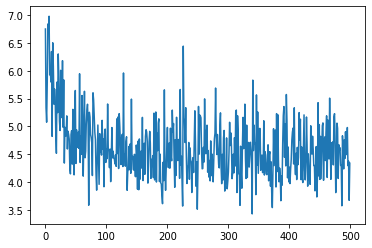

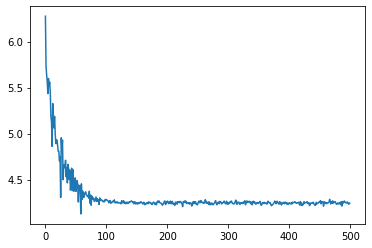

In [19]:
import matplotlib.pyplot as plt
plt.plot(total_l)
plt.show()

plt.plot(test_total_l)
plt.show()

In [4]:
import argparse
import progressbar
def evaluate(module):
    # loss function
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()

    # data loader
    eval_dataset = Eval_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
    eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=4)
    print(eval_dataloader)

    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    with progressbar.ProgressBar(max_value=data_length) as bar:
        for i, sample in enumerate(eval_dataloader):
            input_img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
            sunpos = sample['sp'][0].numpy()

            with torch.no_grad():
                #print("="*20,i,"="*20)
                pred_dis, pred_prrs = module(input_img)
                #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
                #print("pred_dis : ", pred_dis)
                #print("pred_prrs : ", pred_prrs)
                #print(input_img)
                sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
                beta = 0.1
                loss = sun_loss + beta * prr_loss
                sum_loss += loss.item()
                
                # calculate all prediction error
                bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
                pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
                #print('pred_sunpos : ', pred_sunpos)
                suns.append(pred_sunpos)
                suns_gt.append(sunpos)
                sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
                angular.append(sunpos_err)
                # Sky sun kappa beta turbidity
                sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
                sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
                kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
                beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
                tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
                sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])
            bar.update(i)
    # print average prediction errors across all testing dataset
    print("="*20,"FINAL ERROR","="*20)
    print('Testing avg loss:', sum_loss/data_length)
    final_err = sum_err/data_length
    print('Average predictions error:')
    print('sun position (angular error):', final_err[0])
    print('sky color error :', final_err[1])
    print('sun color error:', final_err[2])
    print('kappa error :', final_err[3])
    print('beta error:', final_err[4])
    print('turbidity error:', final_err[5])
    return suns_gt, suns, bins, angular

In [5]:
def main(args):
    print('loading weights ...')
    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    module = IlluminationModule_Shadow().cuda()
    #load pre-trained weight
    module.load_state_dict(torch.load(args.pre_trained))

    print('start evaluating ...')
    suns_gt, suns, bins, angular= evaluate(module)
    print('evaluation done!')
    return suns_gt, suns, bins, angular

In [6]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
  
    parser.add_argument('--pre_trained', default='./shadow_17_9_weights.pth', help='pre-trained weight path')
    
    args = parser.parse_args(args=[])
    
    suns_gt, suns, bins, angular = main(args)

loading weights ...
start evaluating ...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100% (446 of 446) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


==================== FINAL ERROR ====================
Testing avg loss: 4.740509529284832
Average predictions error:
sun position (angular error): 57.70748776458697
sky color error : 0.2241929287734053
sun color error: 1.3189969517106834
kappa error : 0.06661852597856201
beta error: 9.637954501426808
turbidity error: 16.29533871193103
evaluation done!


In [7]:
print(angular)

[20.248004135874996, 77.78828610659875, 5.531638245335527, 5.531638245335527, 95.846416926057, 95.846416926057, 5.488799463466992, 80.50424714863048, 31.62580756777822, 93.68973814827183, 121.86378300764063, 85.464586383137, 85.464586383137, 85.464586383137, 38.850589084999285, 133.85403070290545, 133.85403070290545, 133.85403070290545, 96.78525669313113, 96.78525669313113, 84.3873563561804, 84.3873563561804, 116.61392791757426, 122.68075538060141, 124.36161459054188, 12.620146089925553, 23.7766248474527, 12.620146089925553, 42.90914619596314, 12.620146089925553, 2.586796334354984, 72.59193473113298, 3.945330318728579, 2.545339845064745, 101.01515981601152, 1.768955336561102, 108.61906533995136, 123.9142174777166, 89.45605591451758, 19.380589080092633, 98.09923708313627, 113.12541428429353, 52.339336595252355, 4.272554516422548, 101.37298089962874, 101.37298089962874, 101.37298089962874, 5.0153327655385445, 5.0153327655385445, 16.957276387390365, 18.451598321150716, 89.04405945562274, 